In [1]:
from codes.python import load_database,ECG_denoising
from codes.python import QRS_detector
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
import operator
from numpy import array
import sys
import csv
import os
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing, plot
from codes.python import heartbeat_segmentation as shs
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from codes.python import curve_smoothing 
import pywt
from biosppy.signals import ecg
from sklearn import metrics
#import waipy
import operator


In [2]:
mitdb = load_database.load_mitdb()
mitdb.segment_beats()

C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/100
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/100.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/100.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/100pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/101
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/101.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/101.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/101pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/102
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/102.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/102.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/102pt

C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/201.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/201pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/202
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/202.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/202.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/202pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/203
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/203.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/203.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/203pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/205
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/205

Filtered MLII records from : 102
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 102 completes.
Start segmenting records: 103
Filtered MLII records from : 103
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 103 completes.
Start segmenting records: 104
Filtered MLII records from : 104
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 104 completes.
Start segmenting records: 105
Filtered MLII records from : 105
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 105 completes.
Start segmenting records: 106
Filtered MLII records from : 106
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 106 completes.
Start segmenting records: 107
Filtered MLII records from : 107
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 107 completes.
Start segmenting records: 108
Filtered MLII records from : 108
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 108 completes.
Start segmentin

In [3]:

def is_class_MIT(classAnttd):
    MITBIH_classes = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F']#, 'P', '/', 'f', 'u']
    if classAnttd in MITBIH_classes:
        return True
    else:
        return False
        

def check_class_AAMI(classAnttd, class_AAMI):
    AAMI_classes = []
    AAMI_classes.append(['N', 'L', 'R'])                    # N
    AAMI_classes.append(['A', 'a', 'J', 'S', 'e', 'j'])     # SVEB 
    AAMI_classes.append(['V', 'E'])                         # VEB
    AAMI_classes.append(['F'])
    for i in range(0,len(AAMI_classes)):

        if classAnttd in AAMI_classes[i]:
            class_AAMI = i      

    return class_AAMI

def segment(signal,pos,winL,winR,size_RR_max):
    lst = list(signal[pos - size_RR_max : pos + size_RR_max])
    
    
    if(signal[pos] < 0):
        beat_pos = [abs(x) for x in lst]
        beat_pos = enumerate(beat_pos)
        index, value  = max(beat_pos, key=operator.itemgetter(1))
        pos = (pos - size_RR_max) + index
    
    else:
        beat_pos = enumerate(lst)
        index, value  = max(beat_pos, key=operator.itemgetter(1))
        pos = (pos - size_RR_max) + index

    beat_poses = list(range(pos - winL, pos + winR))
    beat_poses = [int(i) for i in beat_poses]
    return beat_poses,pos

def r_peak_and_annotation(signal,annotations, indexes, winL=180, winR=180,size_RR_max=5):
    class_ID = []
    
    originalPoses = []
   
    R_poses = []
    beat_class = []
    class_AAMI = -1
    
    for a in annotations:
    
        aS = a.split()
        pos = int(aS[1])

       

        if(len(signal) < len(indexes)):
            break

        if(indexes[len(indexes)-1] < pos):
            break

        if(indexes[0] > pos):
            continue
        
        originalPos = int(aS[1])
        classAnttd = str(aS[2])

        if pos > size_RR_max and pos < (len(signal) - size_RR_max):
            beat_poses,pos=segment(signal,pos,winL,winR, size_RR_max)
        #time_beat = list(time[beat_poses[0] : beat_poses[len(beat_poses)-1]+1])
            pos = pos - indexes[0]
            if(pos > winL and pos < (len(indexes) - winR)):
                
                R_poses.append(pos)
                class_AAMI = check_class_AAMI(classAnttd, class_AAMI)
                class_ID.append(class_AAMI)
                beat_class.append(classAnttd)
                originalPos = originalPos-indexes[0]
                originalPoses.append(originalPos)

    return beat_class, class_ID, R_poses, originalPoses

def segment_beat(signal,r_poses, upper_left_limit=0, upper_right_limit=0, winL=180,  winR=180,size_RR_max=5):
    upper_left_limit = winL+upper_left_limit
    upper_right_limit = winR+upper_right_limit
    beats = []
    beat_pos = []
    for pos in r_poses:
        
        if pos > size_RR_max and pos < (len(signal) - size_RR_max ):
            beat_poses,pos=segment(signal,pos,winL,winR, size_RR_max)
            if(pos <= upper_left_limit):
                beat = signal[pos - winL : pos + upper_right_limit]
                beat_poses = list(range(pos - winL, pos + upper_right_limit))
                beat_poses = [int(i) for i in beat_poses]
                #print(beat, pos)
                
            if(pos >= (len(signal) - upper_right_limit)):
                beat = signal[pos - upper_left_limit : pos + winR]
                beat_poses = list(range(pos - upper_left_limit, pos + winR))
                beat_poses = [int(i) for i in beat_poses]
               # print("here", str(pos))
                #print(beat)

            if(pos > upper_left_limit and pos < (len(signal) - upper_right_limit)):
                
                beat = signal[pos - upper_left_limit : pos + upper_right_limit]
                beat_poses = list(range(pos - upper_left_limit, pos + upper_right_limit))
                beat_poses = [int(i) for i in beat_poses]
                
            if(pos > winL and pos < (len(signal) - winR)):
                beats.append(beat)
                beat_pos.append(beat_poses)
                
                #print(pos)
                
    return np.asarray(beats), np.asarray(beat_pos)

def r_peak(signal,r_peak, winL=180, winR=180,size_RR_max=5):
    
    R_poses = []
    class_AAMI = -1
    for r in r_peak:
        pos = r
        if(pos > len(signal)):
            break  
        
        if pos > size_RR_max and pos < (len(signal) - size_RR_max):
            beat_poses,pos=segment(signal,pos,winL,winR, size_RR_max)
            
            if(pos > winL and pos < (len(signal) - winR)):
               
                R_poses.append(pos)
                
    return R_poses


def average(numbers):
    return float(sum(numbers)) / len(numbers)

In [4]:
def peak_properties_extractor(sig,start_point=None,end_point=None,height=None, distance=None, width = None, plateau_size=None):
    sig = sig[start_point:end_point]
    peaks,properties  = np.asarray(signal.find_peaks(sig, height=height, distance=distance,width=width,plateau_size=plateau_size))
    return peaks,properties

def point_transform_to_origin(por,point):
    point_from_origin = por + point 
    return point_from_origin

def origin_to_new_point(por,point_from_origin):
    point = point_from_origin - por
    return point

def peak_duration(time,right_edge, left_edge,point_from_origin):
    right_edge = point_transform_to_origin(point_from_origin,right_edge)
    left_edge = point_transform_to_origin(point_from_origin,left_edge)
    
    return float(time[right_edge]-time[left_edge])

def sub_signal_interval(time, start_point, end_point,point_from_origin):
    start_point = point_transform_to_origin(point_from_origin,start_point)
    end_point = point_transform_to_origin(point_from_origin,end_point)
    
    return float(time[end_point]-time[start_point])

def peak_height(signal, peak, prominence,point_from_origin):
    peak = point_transform_to_origin(point_from_origin,peak)
    height = (signal[peak] - prominence) - singal[peak]
    return height

def area_under_curve(signal,samples,point_from_origin):
    samples = [point_transform_to_origin(i,point_from_origin) for i in samples]
    area = metrics.auc(samples,signal[samples])
    return area
    

In [5]:
mit100 = mitdb.patient_records[0]



In [6]:
beats, beat_pos = segment_beat(mit100.filtered_MLII, mit100.segmented_R_pos,upper_left_limit=300, upper_right_limit=300)

In [7]:
pwaves = mit100.annotated_p_waves_pos
twaves = mit100.annotated_t_waves_pos

In [8]:
len(pwaves)
len(twaves)

2448

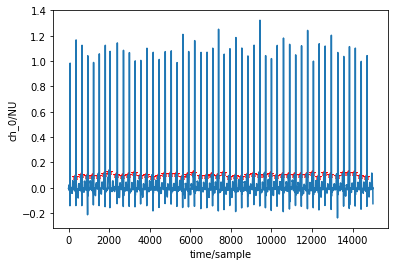

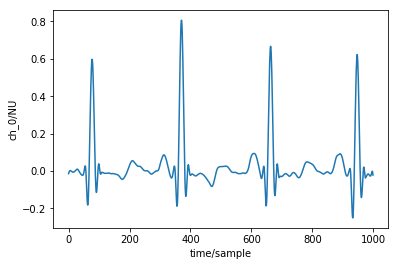

In [10]:


p_waves = mit100.annotated_p_waves_pos[0:50]

filtered_np100 = savgol_filter(mit100.filtered_MLII[0:1000],51,7)

p_waves = [int(b) for b in p_waves]
#p_waves = list([210, 400])
p_wave = np.asarray(p_waves)
wfdb.plot_items(signal=mit100.filtered_MLII[0:15000], ann_samp=[p_wave])
wfdb.plot_items(signal=filtered_np100)#, ann_samp=[p_wave])



In [11]:
p_waves = []
t_waves = []
averages_p = []
averages_t = []
diffs_p = []
diffs_t = []
max_diff = 1000
for i in mitdb.patient_records:
    diffs = []
    p_waves.extend(i.annotated_p_waves_pos)
    t_waves.extend(i.annotated_t_waves_pos)
    for j in range(0,len(i.annotated_p_waves_pos)-1):
        diff=i.annotated_p_waves_pos[j+1] - i.annotated_p_waves_pos[j]
        if(diff <= max_diff):
            diffs.append(diff)
        
    diffs_p.extend(diffs)
    averages = round(average(diffs),2)
    averages_p.append(averages)
    
    diffs = []
    for j in range(0,len(i.annotated_t_waves_pos)-1):
        diff=i.annotated_t_waves_pos[j+1] - i.annotated_t_waves_pos[j]
        if(diff <= max_diff):
            diffs.append(diff)
    diffs_t.extend(diffs)
    averages = round(average(diffs),2)
    averages_t.append(averages)
    #averages_p.append(round(average(p_waves),2))
    #averages_t.append(round(average(t_wavess),2))
    
    
p_waves = [int(b) for b in p_waves]
t_waves = [int(t) for t in t_waves]

In [12]:
r_peaks = []

for i in mitdb.patient_records:
    
    r_peaks.extend(i.segmented_R_pos)
   
    
    


In [13]:
len(r_peaks)

112543

In [14]:

p_all_diffs = []

for i in range(0, len(p_waves)-1):
    
        
    diff=p_waves[i+1] - p_waves[i]
        
    p_all_diffs.append(diff)



t_all_diffs = []

for i in range(0, len(t_waves)-1):
    
        
    diff=t_waves[i+1] - t_waves[i]
        
    t_all_diffs.append(diff)
 

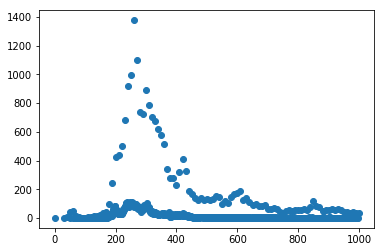

In [15]:
x ,y  = np.unique(diffs_p, return_counts=True) # counting occurrence of each loan
plt.scatter(x,y)



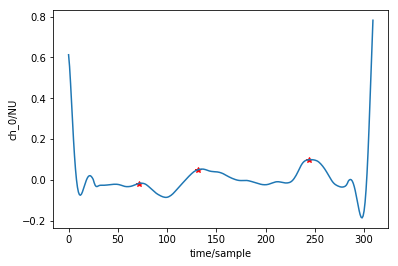

{'plateau_sizes': array([1, 1, 1], dtype=int64),
 'left_edges': array([ 71, 131, 244], dtype=int64),
 'right_edges': array([ 71, 131, 244], dtype=int64),
 'peak_heights': array([-0.01139368,  0.05664954,  0.11212205]),
 'prominences': array([0.02562751, 0.08226536, 0.19679668]),
 'left_bases': array([61, 96, 96], dtype=int64),
 'right_bases': array([ 96, 199, 299], dtype=int64),
 'widths': array([ 9.28088962, 39.68761232, 33.40787386]),
 'width_heights': array([-0.02420744,  0.01551686,  0.01372371]),
 'left_ips': array([ 67.97503289, 123.16882712, 229.89901822]),
 'right_ips': array([ 77.25592251, 162.85643944, 263.30689208])}

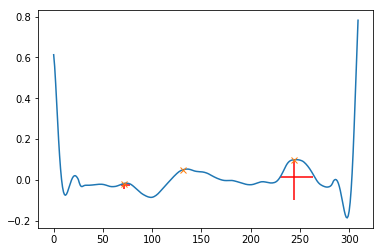

In [16]:
sig = mit100.MLII[mit100.segmented_R_pos[2001]:mit100.segmented_R_pos[2002]]
filter_FIR = ECG_denoising.ECG_FIR_filter()

filtered_signal = ECG_denoising.denoising_signal_FIR(sig,filter_FIR)
filtered_np100 = savgol_filter(mit100.filtered_MLII[0:10000],51,7)
savgol_signal = savgol_filter(filtered_signal,51,7)
#peaks = processing.find_peaks(filtered_np100)


peaks = signal.find_peaks_cwt(savgol_signal, np.arange(1, 50))#, max_distances=np.arange(1, 100)/4)

second_peak = 0
if(mit100.filtered_MLII[mit100.segmented_R_pos[1]] > mit100.filtered_MLII[mit100.segmented_R_pos[2]]):
    second_peak = mit100.filtered_MLII[mit100.segmented_R_pos[2]]
else:
    second_peak = mit100.filtered_MLII[mit100.segmented_R_pos[1]]

peaks,properties  = np.asarray(signal.find_peaks(filtered_signal, height=[min(filtered_signal),second_peak-0.05], distance=40,width=[5,100],plateau_size=[0,100] ))#, max_distances=np.arange(1, 100)/4)

left_base = np.asarray(properties["left_bases"])
right_bases = np.asarray(properties["right_bases"])
left_ips = np.asarray(properties["left_ips"])
right_ips = np.asarray(properties["right_ips"])
left_ips = [int(i) for i in left_ips]
right_ips = [int(i) for i in right_ips]

left_ips = np.asarray(left_ips)
right_ips = np.asarray(right_ips)
wfdb.plot_items(signal=savgol_signal, ann_samp=[peaks])

plt.plot(savgol_signal)
plt.plot(peaks, savgol_signal[peaks], "x")
plt.vlines(x=peaks, ymin=savgol_signal[peaks] - properties["prominences"],ymax = savgol_signal[peaks], color = "r1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],xmax=properties["right_ips"], color = "r1")
properties

#find using cluster.

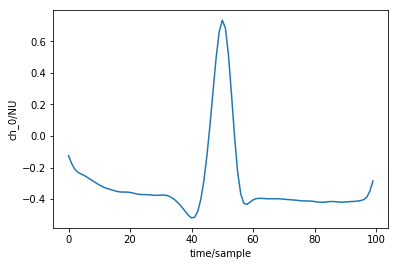

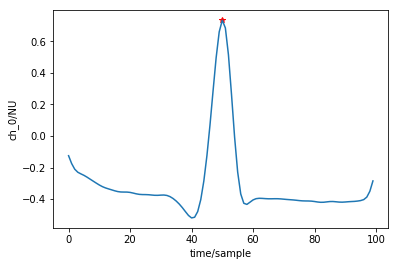

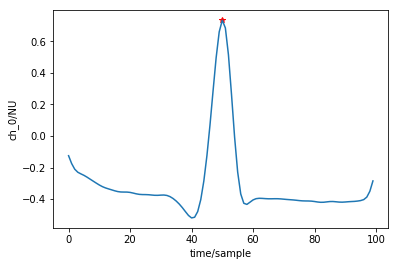

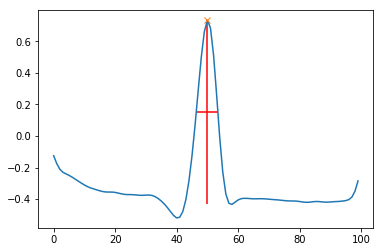

In [17]:
sig = mit100.MLII[mit100.segmented_R_pos[1]-50:mit100.segmented_R_pos[1]+50]

filter_FIR = ECG_denoising.ECG_FIR_filter()

filtered_signal = ECG_denoising.denoising_signal_FIR(sig,filter_FIR)
fitlered100 = filtered_signal
savgol_signal = savgol_filter(filtered_signal,51,7)

wfdb.plot_items(signal=filtered_signal)

peaks,properties = peak_properties_extractor(filtered_signal,height=None, distance=20, width = [5,100], plateau_size=[0,100])
#peaks,properties  = np.asarray(signal.find_peaks(filtered_signal, height=min(filtered_signal), distance=20,width=[5,100],plateau_size=[0,100] ))#, max_distances=np.arange(1, 100)/4)
wfdb.plot_items(signal=filtered_signal,ann_samp=[peaks])

left_base = np.asarray(properties["left_bases"])
right_bases = np.asarray(properties["right_bases"])
left_ips = np.asarray(properties["left_ips"])
right_ips = np.asarray(properties["right_ips"])
left_ips = [int(i) for i in left_ips]
right_ips = [int(i) for i in right_ips]

left_ips = np.asarray(left_ips)
right_ips = np.asarray(right_ips)
wfdb.plot_items(signal=filtered_signal, ann_samp=[peaks])

plt.plot(filtered_signal)
plt.plot(peaks, filtered_signal[peaks], "x")
plt.vlines(x=peaks, ymin=filtered_signal[peaks] - properties["prominences"],ymax = filtered_signal[peaks], color = "r1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],xmax=properties["right_ips"], color = "r1")

##find R peak using the heighest peak.

In [18]:
mit207 = load_database.load_patient_record("mitdb","207")
mit207.set_segmented_beats_r_pos(winL=100,winR=200)

    

C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/207
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/207.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/207.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/207pt.csv
Start segmenting records: 207
Filtered MLII records from : 207
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 207 completes.


In [19]:
sig = []
peaks = []
properites_list= []
heights = []
durations = []
areas = []
onset = []
offset = []
max_peaks = []
min_peaks = []

for r in mit207.segmented_R_pos:
    
    distance=20
    width = [0,100] 
    plateau_size=[0,100]
    start_point = r-50
    end_point = r+50
   
    if(mit207.filtered_MLII[r] >= 0):
        sig = mit207.filtered_MLII[start_point:end_point]
        height = min(sig)   
        peak,properties = peak_properties_extractor(sig,height=height, distance=distance, width = width, plateau_size=plateau_size)
    else:
        sig = -mit207.filtered_MLII[start_point:end_point]
        height = min(sig)   
        peak,properties = peak_properties_extractor(sig,height=height, distance=distance, width = width, plateau_size=plateau_size)
    
    
    savgol_signal = savgol_filter(sig,41,9)
    height = min(savgol_signal)   
    peak_savol,properties_savol = peak_properties_extractor(savgol_signal,height=height, distance=distance, width = width, plateau_size=plateau_size)
    #print()
    #print(peak)
    savgol_signal = savgol_signal[peak_savol]
    #print(peak_savol)
    #print(sig)
    value = max(savgol_signal)
    #print(value)
    if(len(peak_savol) == 0):
        print(len(peak_savol),r)
        print(peak_savol)
    index = np.where(savgol_signal==value)
    #print(index)
    #print(index)
    index = int(index[0])
    
    peak_savol = peak_savol[index]
    peak_savol = point_transform_to_origin(start_point,peak_savol)
    peaks.append(peak_savol)
    left_ips = np.asarray(properties_savol["left_ips"])
    right_ips = np.asarray(properties_savol["right_ips"])
    left_ips = [int(i) for i in left_ips]
    right_ips = [int(i) for i in right_ips]
    
    left_edge = left_ips[index]
    right_edge = right_ips[index]
    
    
    duration = round(peak_duration(time=mit207.time,right_edge=right_edge, left_edge=left_edge,point_from_origin=start_point),3)
    if(duration<0.01):
        min_peaks.append(r)
    durations.append(duration)

   
    #properites_list.append(properties)


[9464, 21826, 22769, 81408, 559055, 570217, 575446, 580129, 582731, 584845]

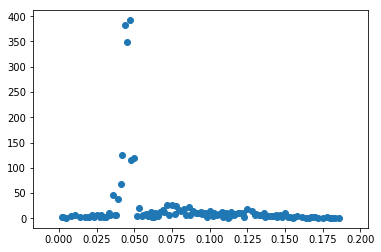

In [20]:
x ,y  = np.unique(durations, return_counts=True) # counting occurrence of each loan
plt.scatter(x,y)

min_peaks

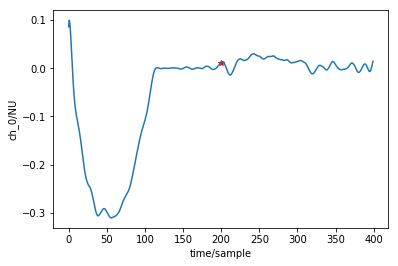

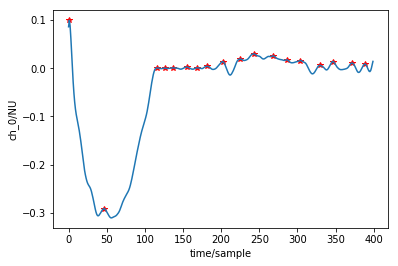

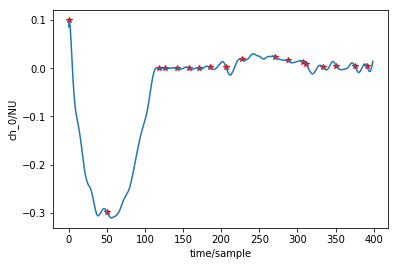

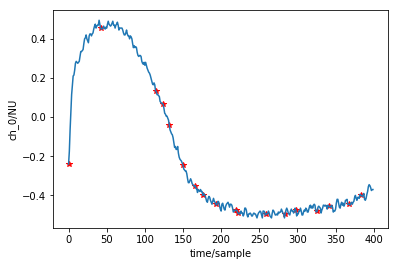

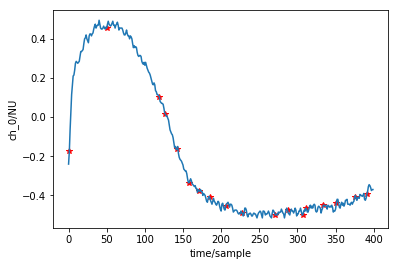

In [21]:
index = list(range(21826-200,21826+200))
sig = -mit207.MLII[21826-200:21826+200]
fitlered100 = mit207.MLII[21826-200:21826+200]
filter_FIR = ECG_denoising.ECG_FIR_filter()


filtered_signal = ECG_denoising.denoising_signal_FIR(sig,filter_FIR)
savgol_signal = savgol_filter(filtered_signal,41,9)
r_pos = np.asarray(shs.r_peak_detector(mit207.filtered_MLII,mit207.annotations,index))
wfdb.plot_items(signal=savgol_signal,ann_samp=[r_pos])

peaks,properties  = np.asarray(signal.find_peaks(savgol_signal, height=min(savgol_signal), distance=10,width=[0,100],plateau_size=[0,100] ))#, max_distances=np.arange(1, 100)/4)
wfdb.plot_items(signal=savgol_signal,ann_samp=[peaks])

left_base = np.asarray(properties["left_bases"])
right_bases = np.asarray(properties["right_bases"])
left_ips = np.asarray(properties["left_ips"])
right_ips = np.asarray(properties["right_ips"])
left_ips = [int(i) for i in left_ips]
right_ips = [int(i) for i in right_ips]

left_ips = np.asarray(left_ips)
right_ips = np.asarray(right_ips)
wfdb.plot_items(signal=savgol_signal,ann_samp=[right_ips])
wfdb.plot_items(signal=fitlered100, ann_samp=[left_ips])
wfdb.plot_items(signal=fitlered100, ann_samp=[right_ips])


## find Q and s using the left and right most index peak from R 

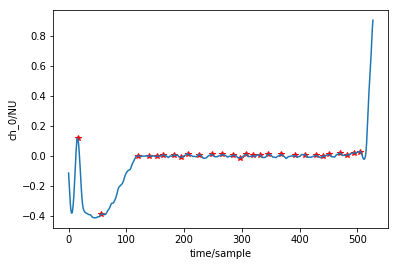

[]

In [22]:

#calculate the off and on set of R-peak first before calculating the the P and T wave. From the onset one can calulate the P and T wave
indexes = list(range(mit207.segmented_R_pos[0]-5,mit207.segmented_R_pos[1]))

#indexes = list(range(0,1500))
mit207_sub = mit207.filtered_MLII[indexes]
r_poses = shs.r_peak_detector(mit207.filtered_MLII,mit207.annotations,indexes)
peaks,properties  = np.asarray(signal.find_peaks(mit207_sub, height=min(mit207_sub), distance=10,width=[0,50],plateau_size=[0,100] ))#, max_distances=np.arange(1, 100)/4)

peak = np.asarray(peaks)
type(peak)
wfdb.plot_items(signal=mit207_sub,ann_samp=[peak])
peak
r_poses

In [23]:
signal = mit100.MLII[mit100.segmented_R_pos[0]:mit100.segmented_R_pos[1]]
noise = np.random.normal(0,0.1,len(signal))
noisy = signal + noise
filter_FIR = ECG_denoising.ECG_FIR_filter()

filtered_signal = ECG_denoising.denoising_signal_FIR(signal,filter_FIR)
filtered_noisy = ECG_denoising.denoising_signal_FIR(noisy,filter_FIR)

savgol_signal = savgol_filter(filtered_signal,51,7)
savgol_noisy = savgol_filter(filtered_noisy,51,7)
savgol_signal = np.array(savgol_signal)
indices = peakutils.indexes(savgol_signal, thres=0.02/max(savgol_signal), min_dist=0.1)

wfdb.plot_items(signal=signal)
wfdb.plot_items(signal=noisy)
wfdb.plot_items(signal=filtered_signal,  ann_samp=[indices])
wfdb.plot_items(signal=filtered_noisy)
wfdb.plot_items(signal=savgol_signal)
wfdb.plot_items(signal=savgol_noisy)

NameError: name 'peakutils' is not defined

In [ ]:
type(indices)

In [ ]:
out = ecg.ecg(signal=mit100.filtered_MLII[0:20000], sampling_rate=1000., show=True)
out

In [ ]:
x = pywt.data.ecg()
#plt.plot(x)
#plt.legend(['Original signal'])
w = pywt.Wavelet('sym5')
plt.plot(w.dec_lo)
coeffs = pywt.wavedec(x, w, level=6)
plt.stem(coeffs[1]); plt.legend(['Lvl 1 detail coefficients'])

coeffs[1]

In [ ]:
def reconstruction_plot(yyy, **kwargs):
    """Plot signal vector on x [0,1] independently of amount of values it contains."""
    plt.plot(np.linspace(0, 1, len(yyy)), yyy, **kwargs)

reconstruction_plot(pywt.waverec(coeffs, w)) # full reconstruction 
#reconstruction_plot(pywt.waverec(coeffs[:-1] + [None] * 1, w)) # leaving out detail coefficients up to lvl 5
#reconstruction_plot(pywt.waverec(coeffs[:-2] + [None] * 2, w)) # leaving out detail coefficients up to lvl 4
#reconstruction_plot(pywt.waverec(coeffs[:-3] + [None] * 3, w)) # leaving out detail coefficients up to lvl 3
reconstruction_plot(pywt.waverec(coeffs[:-4] + [None] * 4, w)) # leaving out detail coefficients up to lvl 2
#reconstruction_plot(pywt.waverec(coeffs[:-5] + [None] * 5, w)) # leaving out detail coefficients up to lvl 1
reconstruction_plot(pywt.waverec(coeffs[:-6] + [None] * 6, w)) # leaving out all detail coefficients = reconstruction using lvl1 approximation only
plt.legend(['Full reconstruction', 'Reconstruction using detail coefficients lvl 1+2', 'Reconstruction using lvl 1 approximation only'])